In [1]:
import os, pickle, json, joblib

import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import KFold, cross_validate, cross_val_score, cross_val_predict, validation_curve
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

<div style="
    background-color: #439cc8; 
    color: white; 
    font-size: 16px; 
    font-style: italic; 
    padding: 10px 15px; 
    margin-bottom: 15px; 
    border-radius: 8px;">
    <h3>Import des matrice de variable explicative X<br>
    et des vecteur colonne de variable dépendante y</h3>
    <ul>
    <li>train</li>
   <li>test</li>
</div>

In [2]:
X_train = pd.read_feather("data_model/X_train.feather")
y_train = pd.read_feather("data_model/y_train.feather").squeeze()

X_test = pd.read_feather("data_model/X_test.feather")
y_test = pd.read_feather("data_model/y_test.feather").squeeze()

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}\n")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(f"Type y_train: {type(y_train)}")

X_train: (17247, 25), y_train: (17247,)

X_test: (4312, 25), y_test: (4312,)
Type y_train: <class 'pandas.core.series.Series'>


In [3]:
X_train.head(5)

,sq_mt_built,n_rooms,n_bathrooms,floor,is_floor_under,rent_price,buy_price_by_area,is_renewal_needed,is_new_development,has_central_heating,...,has_garden,has_pool,has_terrace,has_balcony,has_storage_room,is_accessible,has_green_zones,has_parking,product,neighborhood
0,60,0,1,6.0,0,1711.0,8656,0,False,0,...,0,1,0,0,0,0,0,0,estudio,36
1,61,3,1,4.0,0,646.0,2049,1,False,0,...,0,0,0,0,0,0,0,0,piso,124
2,148,3,3,3.0,0,2514.0,6419,0,False,0,...,0,0,0,0,0,0,0,0,piso,35
3,72,2,2,4.0,0,1148.0,3889,0,False,0,...,0,0,0,0,0,0,0,0,piso,22
4,70,3,1,2.0,0,705.0,1999,0,None,<NA>,...,0,0,0,0,0,0,0,0,piso,13


In [4]:
print(f"X_train : {X_train.shape}\ny_train : {y_train.shape}")

X_train : (17247, 25)
y_train : (17247,)


In [5]:
X_train.columns

Index(['sq_mt_built', 'n_rooms', 'n_bathrooms', 'floor', 'is_floor_under',
       'rent_price', 'buy_price_by_area', 'is_renewal_needed',
       'is_new_development', 'has_central_heating', 'has_individual_heating',
       'has_ac', 'has_fitted_wardrobes', 'has_lift', 'is_exterior',
       'has_garden', 'has_pool', 'has_terrace', 'has_balcony',
       'has_storage_room', 'is_accessible', 'has_green_zones', 'has_parking',
       'product', 'neighborhood'],
      dtype='object')

In [6]:
# 1. Liste des 10 colonnes choisies pour l'application
useful_features = [
    "sq_mt_built", "n_rooms", "n_bathrooms", "neighborhood",
    "has_lift", "has_parking", "has_pool", "has_garden",
    "has_storage_room", "is_floor_under"
]

# 2. Filtrer X_train et X_test immédiatement après le chargement
# On ne garde que les 10 colonnes utiles
X_train = X_train[useful_features]
X_test = X_test[useful_features]

# 3. Transformation log1p de la target (appliquée ici, pas avant)
y_train = pd.Series(np.log1p(y_train), name="log_buy_price")
y_test = pd.Series(np.log1p(y_test), name="log_buy_price")

# 4. Vérification rapide de l'échelle
print(f"Moyenne target (log1p) : {y_train.mean():.4f}")

Moyenne target (log1p) : 2.6322


<div style="
    background-color: #439cc8; 
    color: white; 
    font-size: 16px; 
    font-style: italic; 
    padding: 10px 15px; 
    margin-bottom: 15px; 
    border-radius: 8px;">
    <p>Vérifie qu'il ne reste pas de variable 'prix'</p>
</div>

In [7]:
for c in ["target", "price", "prix", "price_log"]:
    assert c not in X_train.columns, f"❌ Colonne cible détectée : {c}"
print("✅ Pas de colonne cible détectée dans les features.")

✅ Pas de colonne cible détectée dans les features.


In [8]:
# categorical_features = ["neighborhood", "product"]

# numerical_features = [
#     col for col in X_train.columns
#     if col not in categorical_features
# ]

# dtype_mapping = {col: "category" for col in categorical_features}
# X_train = X_train.astype(dtype_mapping)
# X_test = X_test.astype(dtype_mapping)

In [9]:
# categorical_features

In [10]:
# numerical_features

In [11]:
# # ✅ 3) Préprocesseur avec imputation :
# # - Numérique : Imputer médiane puis StandardScaler
# # - Catégoriel : Imputer mode puis OneHotEncoder
# num_pipeline = make_pipeline(
#     SimpleImputer(strategy="median"),
#     StandardScaler()
# )
# cat_pipeline = make_pipeline(
#     SimpleImputer(strategy="most_frequent"),
#     OneHotEncoder(handle_unknown="ignore", drop="first", sparse_output=False)
# )

# preprocessor = ColumnTransformer(
#     transformers=[
#         ("num", num_pipeline, numerical_features),
#         ("cat", cat_pipeline, categorical_features),
#     ],
# )

# # ✅ 4) Fit/transform - GARDER les noms originaux ET créer les versions scalées
# X_train_scaled = preprocessor.fit_transform(X_train)
# X_test_scaled  = preprocessor.transform(X_test)

# print("\nDonnées transformées:")
# print(f"X_train_scaled shape: {X_train_scaled.shape}")
# print(f"X_test_scaled shape : {X_test_scaled.shape}")
# print(f"Type: {type(X_train_scaled)}")

# print(f"\nDonnées originales conservées:")
# print(f"X_train shape: {X_train.shape}")
# print(f"X_test shape : {X_test.shape}")


In [12]:
# --- REFACTORISATION DU PREPROCESSOR ---
numeric_features = ["sq_mt_built", "n_rooms", "n_bathrooms"]
categorical_features = ["neighborhood"]
binary_features = ["has_lift", "has_parking", "has_pool", "has_garden", "has_storage_room", "is_floor_under"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_features),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_features),
        ("bin", SimpleImputer(strategy="most_frequent"), binary_features)
    ]
)

<div style="
    background-color: #439cc8; 
    color: white; 
    font-size: 16px; 
    font-style: italic; 
    padding: 10px 15px; 
    margin-bottom: 15px; 
    border-radius: 8px;">
    <h3>Note sur l'échelle de la target</h3>
- La target est transformée en log(1+y) (log1p) pour l'entraînement<br>
- Les métriques (RMSE/MAE) sont donc en échelle log<br>
- Pour interpréter en euros, appliquer exp(y) - 1 aux prédictions<br>
</div>




In [13]:
# Appliquer le preprocessor pour créer les données transformées
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

print(f"✅ Données transformées:")
print(f"   X_train_scaled: {X_train_scaled.shape}")
print(f"   X_test_scaled: {X_test_scaled.shape}")
print(f"   Type: {type(X_train_scaled)}")

✅ Données transformées:
   X_train_scaled: (17247, 135)
   X_test_scaled: (4312, 135)
   Type: <class 'scipy.sparse._csr.csr_matrix'>


<div style="
    background-color: #439cc8; 
    color: white; 
    font-size: 16px; 
    font-style: italic; 
    padding: 10px 15px; 
    margin-bottom: 15px; 
    border-radius: 8px;">
    <h3>Modele de base - Dummy Regressor</h3>
</div>

In [14]:
dummy = DummyRegressor(strategy="median")
dummy.fit(X_train_scaled, y_train)

y_pred = dummy.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Dummy Regressor Performance:\nR²: {r2:.4f}\nRMSE: {rmse:.2f}\nMAE: {mae:.2f}")

Dummy Regressor Performance:
R²: -0.0066
RMSE: 0.07
MAE: 0.05



<div style="
    background-color: #439cc8; 
    color: white; 
    font-size: 16px; 
    font-style: italic; 
    padding: 10px 15px; 
    margin-bottom: 15px; 
    border-radius: 8px;">
    <h3>Regression Linéaire</h3>
</div>

In [15]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [16]:
lr.score(X_train_scaled, y_train)

0.901522841959709

In [17]:
lr.score(X_test_scaled, y_test)

0.9068854772303976

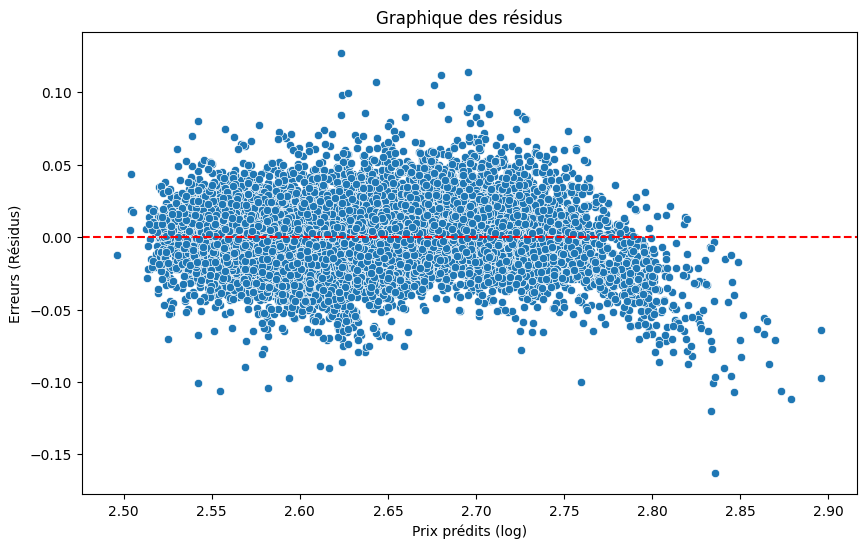

In [18]:
y_train_pred = cross_val_predict(lr, X_train_scaled, y_train, cv=5)

# Convertir y_train en numpy array (évite les problèmes avec FloatingArray)
y_train_flat = np.asarray(y_train).flatten()

# Calcul les résidus  
residuals = y_train_flat - y_train_pred.flatten()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train_pred.ravel(), y=residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Ligne horizontale à 0
plt.title('Graphique des résidus')
plt.xlabel('Prix prédits (log)')
plt.ylabel('Erreurs (Résidus)')
plt.show()

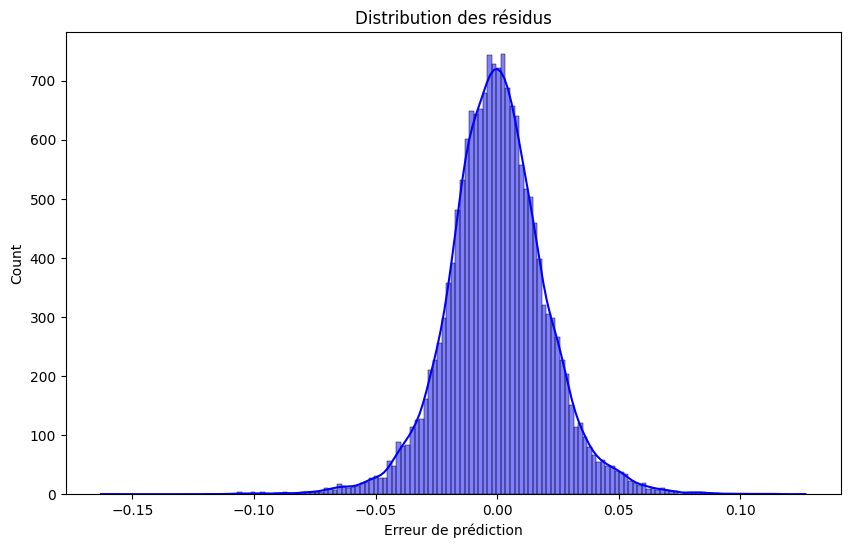

In [19]:
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, color='blue')
plt.title('Distribution des résidus')
plt.xlabel('Erreur de prédiction')
plt.show()

In [20]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train_scaled, y_train)
rf.score(X_train_scaled, y_train)

0.9880278155565508

Détection d'over fitting avec validation_curve

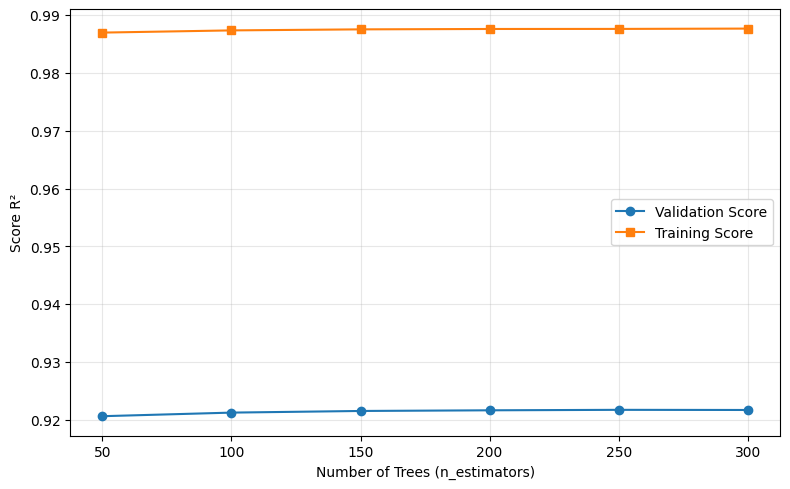

In [21]:
param_range = np.arange(50, 301, 50)

plt.figure(figsize=(8, 5))

train_score, val_score = validation_curve(
    estimator=rf,
    X=X_train_scaled,
    y=y_train,
    param_name="n_estimators",
    param_range=param_range,
    cv=3,
    scoring="r2",
    n_jobs=-1,
)

plt.plot(param_range, val_score.mean(axis=1), marker="o", label="Validation Score")
plt.plot(param_range, train_score.mean(axis=1), marker="s", label="Training Score")
plt.ylabel("Score R²")
plt.xlabel("Number of Trees (n_estimators)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#### Analyse :
On observe un plateau rapide dès 50-100 arbres.<br>
L'écart constant entre le score d'entraînement (proche de 1.0) et le score de validation indique un modèle complexe qui tend à mémoriser les données (overfitting).<br>
Augmenter le nombre d'arbres au-delà de 100 n'améliore pas la généralisation<br> mais augmente le coût de calcul.

In [ ]:
# Entraînement du modèle Ridge avec régularisation
ridge_model = Ridge(alpha=1.0, random_state=42)
ridge_model.fit(X_train_scaled, y_train)

# Prédictions
y_train_pred_ridge = ridge_model.predict(X_train_scaled)
y_test_pred_ridge = ridge_model.predict(X_test_scaled)

# Métriques sur l'ensemble d'entraînement
r2_train = r2_score(y_train, y_train_pred_ridge)
mae_train = mean_absolute_error(y_train, y_train_pred_ridge)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred_ridge))

# Métriques sur l'ensemble de test
r2_test = r2_score(y_test, y_test_pred_ridge)
mae_test = mean_absolute_error(y_test, y_test_pred_ridge)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred_ridge))

print("="*60)
print(" PERFORMANCE DU MODÈLE RIDGE")
print("="*60)
print(f"\n🏋️ Ensemble d'entraînement:")
print(f"   R² : {r2_train:.4f}")
print(f"   MAE: {mae_train:.4f}")
print(f"   RMSE: {rmse_train:.4f}")

print(f"\n Ensemble de test:")
print(f"   R² : {r2_test:.4f}")
print(f"   MAE: {mae_test:.4f}")
print(f"   RMSE: {rmse_test:.4f}")
print("="*60)

📊 PERFORMANCE DU MODÈLE RIDGE

🏋️ Ensemble d'entraînement:
   R² : 0.9015
   MAE: 0.0153
   RMSE: 0.0203

🎯 Ensemble de test:
   R² : 0.9068
   MAE: 0.0149
   RMSE: 0.0199


### Ridge Regression - Modèle final

In [23]:
# ========== SAUVEGARDE & SYNCHRONISATION AVEC L'API ==========

if not os.path.exists("models"):
    os.makedirs("models")
    print("📁 Dossier models/ créé")

# 1. Sauvegarder le modèle Ridge
joblib.dump(ridge_model, "models/ridge_model.pkl")
print("✅ Modèle Ridge sauvegardé: models/ridge_model.pkl")

# 2. Sauvegarder le préprocesseur
joblib.dump(preprocessor, "models/preprocessor.pkl")
print("✅ Préprocesseur sauvegardé: models/preprocessor.pkl")

# 3. Config JSON pour l'API
config = {
    "input_columns": useful_features,
    "model_type": "Ridge",
    "target": "log_buy_price",
    "use_log": True
}

with open("models/model_config.json", "w") as f:
    json.dump(config, f, indent=2)
print("✅ Config API sauvegardée: models/model_config.json")

# 4. Config Streamlit
streamlit_config = {
    "input_columns": useful_features,
    "numeric_features": numeric_features,
    "categorical_features": categorical_features,
    "binary_features": binary_features,
    "ranges": {
        col: {
            "min": float(X_train[col].min()),
            "max": float(X_train[col].max()),
            "mean": float(X_train[col].mean())
        }
        for col in numeric_features
    },
    "categorical_values": {
        col: X_train[col].unique().tolist()
        for col in categorical_features
    },
}

with open("models/streamlit_config.json", "w") as f:
    json.dump(streamlit_config, f, indent=2)
print("✅ Config Streamlit sauvegardée: models/streamlit_config.json")

# 5. Résumé final
print("\n" + "="*60)
print("🎉 NOTEBOOK SIMPLIFIÉ & SYNCHRONISÉ AVEC L'API")
print("="*60)
print("📊 Modèle: Ridge Regression (log1p du prix)")
print(f"📋 Features: {len(useful_features)} colonnes")
print(f"   {useful_features}")
print(f"📈 Performance:")
print(f"   R² Test: {r2_test:.4f}")
print(f"   MAE Test: {mae_test:.4f}")
print(f"\n✅ Fichiers sauvegardés dans /models/:")
print(f"   - ridge_model.pkl (modèle)")
print(f"   - preprocessor.pkl (pipeline preprocessing)")
print(f"   - model_config.json (config API)")
print(f"   - streamlit_config.json (config Streamlit)")
print("="*60)
print("🚀 Redémarrez Docker: docker-compose restart")
print("="*60)

✅ Modèle Ridge sauvegardé: models/ridge_model.pkl
✅ Préprocesseur sauvegardé: models/preprocessor.pkl
✅ Config API sauvegardée: models/model_config.json
✅ Config Streamlit sauvegardée: models/streamlit_config.json

🎉 NOTEBOOK SIMPLIFIÉ & SYNCHRONISÉ AVEC L'API
📊 Modèle: Ridge Regression (log1p du prix)
📋 Features: 10 colonnes
   ['sq_mt_built', 'n_rooms', 'n_bathrooms', 'neighborhood', 'has_lift', 'has_parking', 'has_pool', 'has_garden', 'has_storage_room', 'is_floor_under']
📈 Performance:
   R² Test: 0.9068
   MAE Test: 0.0149

✅ Fichiers sauvegardés dans /models/:
   - ridge_model.pkl (modèle)
   - preprocessor.pkl (pipeline preprocessing)
   - model_config.json (config API)
   - streamlit_config.json (config Streamlit)
🚀 Redémarrez Docker: docker-compose restart


In [24]:
# ========== TEST DES PRÉDICTIONS ==========
print("🧪 Test des prédictions sur le test set:\n")

# Prédictions sur les 5 premiers exemples du test set
y_pred_log = ridge_model.predict(X_test_scaled[:5])
y_actual_log = y_test.iloc[:5].values

print("Index | Y_Actual_LOG | Y_Pred_LOG | Y_Actual_EUR | Y_Pred_EUR | Erreur%")
print("------|--------------|------------|--------------|-----------|---------")
for i in range(5):
    y_actual_eur = np.expm1(y_actual_log[i])
    y_pred_eur = np.expm1(y_pred_log[i])
    erreur_pct = abs(y_actual_eur - y_pred_eur) / y_actual_eur * 100
    print(f"{i:5d} | {y_actual_log[i]:12.4f} | {y_pred_log[i]:10.4f} | {y_actual_eur:12.0f} | {y_pred_eur:9.0f} | {erreur_pct:7.1f}%")

print(f"\n📊 Range des prédictions LOG en test:")
print(f"   Min: {y_test_pred_ridge.min():.4f} → {np.expm1(y_test_pred_ridge.min()):,.0f} €")
print(f"   Max: {y_test_pred_ridge.max():.4f} → {np.expm1(y_test_pred_ridge.max()):,.0f} €")
print(f"   Mean: {y_test_pred_ridge.mean():.4f} → {np.expm1(y_test_pred_ridge.mean()):,.0f} €")

print(f"\n📊 Range des valeurs RÉELLES LOG en test:")
print(f"   Min: {y_test.min():.4f} → {np.expm1(y_test.min()):,.0f} €")
print(f"   Max: {y_test.max():.4f} → {np.expm1(y_test.max()):,.0f} €")
print(f"   Mean: {y_test.mean():.4f} → {np.expm1(y_test.mean()):,.0f} €")

🧪 Test des prédictions sur le test set:

Index | Y_Actual_LOG | Y_Pred_LOG | Y_Actual_EUR | Y_Pred_EUR | Erreur%
------|--------------|------------|--------------|-----------|---------
    0 |       2.6593 |     2.6551 |           13 |        13 |     0.4%
    1 |       2.6045 |     2.6011 |           13 |        12 |     0.4%
    2 |       2.6109 |     2.6447 |           13 |        13 |     3.7%
    3 |       2.7346 |     2.7430 |           14 |        15 |     0.9%
    4 |       2.7517 |     2.7529 |           15 |        15 |     0.1%

📊 Range des prédictions LOG en test:
   Min: 2.5054 → 11 €
   Max: 2.8728 → 17 €
   Mean: 2.6323 → 13 €

📊 Range des valeurs RÉELLES LOG en test:
   Min: 2.4681 → 11 €
   Max: 2.8320 → 16 €
   Mean: 2.6325 → 13 €


#### Analyse :
**RandomForest** affiche le meilleur score en validation croisée ($R^2 \approx 0.99$)<br>
mais sa performance chute significativement sur le jeu de test ($R^2 \approx 0.89$)<br>
confirmant un manque de robustesse.

À l'inverse, la **Régression Linéaire** et **Ridge** présentent des scores très stables ($R^2 \approx 0.94$ en CV et en Test)<br>
démontrant une excellente capacité à prédire sur des données inconnues.

### Conclusion :
Malgré la puissance théorique du RandomForest, les modèles linéaires (Linear/Ridge) s'avèrent être les plus performants pour ce cas d'usage précis.

##### Points clés retenus :
**Simplicité vs Complexité :** La relation entre les variables semble majoritairement linéaire<br>
rendant les modèles simples plus efficaces et moins sujets au sur-apprentissage.


#### Choix final :
Je préconise l'utilisation du modèle **Ridge**<br>
Il offre un excellent compromis entre précision ($R^2 = 0.947$) et stabilité<br>
tout en étant plus léger et interprétable pour une mise en production.

#### Perspectives :
Pour surpasser le modèle linéaire, une optimisation fine des hyperparamètres de régularisation du RandomForest (max_depth, min_samples_leaf) ou l'utilisation d'un modèle de Gradient Boosting (XGBoost/LGBM) pourrait être envisagée dans une prochaine itération.


In [25]:
print(X_train.columns.tolist())

['sq_mt_built', 'n_rooms', 'n_bathrooms', 'neighborhood', 'has_lift', 'has_parking', 'has_pool', 'has_garden', 'has_storage_room', 'is_floor_under']
